In [4]:
%load_ext autoreload
%autoreload 2

from operaDB import OperaDB
from omronEyeLib import OmronEye
from imageLib import OperaImage
from sensorLib import *
import math
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

#Connection to opera DB
opera = OperaDB('opera_conn.xml', 'lifelog-shimizu')
#cur.execute("select version()")
#print(cur.fetchall())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
connect to opera server


In [5]:
#Get time from video
#desire_date = '2018-07-27'
#desire_date = '2018-08-22'
#desire_date = '2018-09-19'
desire_date = '2018-09-26'

#opera.get_TripListFromTime('2018-09-19', '00:00:00.0000', '23:59:59')
tripLists = opera.get_TripListFromTime(desire_date)
print(tripLists)

                                     id     start_time   length  \
0  6ddb9062-c12c-11e8-ad67-06dc25b93fb2  1537925720190     9973   
1  8b8e87ea-c12c-11e8-ad67-06dc25b93fb2  1537925770180     4822   
2  d70251de-c12c-11e8-ad67-06dc25b93fb2  1537925896758    35510   
3  0c661892-c12d-11e8-ad67-06dc25b93fb2  1537925986346  1588560   
4  de9157c8-c132-11e8-ad7b-06dc25b93fb2  1537928486195    29276   
5  340d32ee-c133-11e8-ad7c-06dc25b93fb2  1537928629543   514081   

                                user_id  
0  687b7332-3c82-11e8-91ea-06dc25b93fb2  
1  687b7332-3c82-11e8-91ea-06dc25b93fb2  
2  687b7332-3c82-11e8-91ea-06dc25b93fb2  
3  687b7332-3c82-11e8-91ea-06dc25b93fb2  
4  687b7332-3c82-11e8-91ea-06dc25b93fb2  
5  687b7332-3c82-11e8-91ea-06dc25b93fb2  


In [17]:
#OBD data
gps = GPS( opera )
column_names, df_gps = gps.get_DataFrameFromTrip( tripLists, 3, -20 )

['id', 'time', 'latitude', 'longitude', 'accuracy', 'user_id', 'bearing', 'bearing_accuracy', 'speed', 'speed_accuracy']


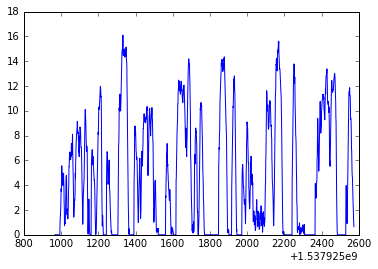

In [18]:
print(column_names)
plt.plot(df_gps['time']/1000,df_gps['speed'])
plt.show()

['id', 'time', 'latitude', 'longitude', 'accuracy', 'user_id', 'bearing', 'bearing_accuracy', 'speed', 'speed_accuracy']


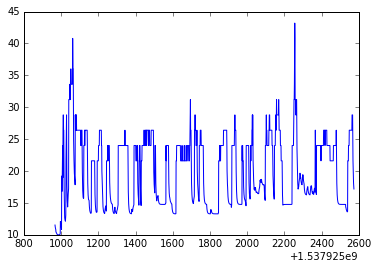

In [19]:
print(column_names)
plt.plot(df_gps['time']/1000,df_gps['accuracy'])
plt.show()

In [25]:
#動画ファイルをグラブ
import cv2

video = OperaImage( opera )
videoCaps = video.get_VideoCapture(tripLists, 5)

print( video.get_SizeFrameCount(videoCaps[0]) )
print( video.get_FPS(videoCaps[0]) )
print( video.get_SizeFrameCount(videoCaps[0])/video.get_FPS(videoCaps[0]) )
w = videoCaps[0].get(cv2.CAP_PROP_FRAME_WIDTH)
h = videoCaps[0].get(cv2.CAP_PROP_FRAME_HEIGHT)

0           1537928629543.mp4
1    1537928629543_inside.mp4
Name: filename, dtype: object
/mnt/s3fs-driveragent-shimizu/video/687b7332-3c82-11e8-91ea-06dc25b93fb2/340d32ee-c133-11e8-ad7c-06dc25b93fb2/1537928629543.mp4
open front video file : False
open room video file : False
0
0.0


ZeroDivisionError: float division by zero

In [21]:
import numpy as np
import pandas as pd
import urllib.request
import folium
from IPython.display import display

loc = [df_gps['latitude'][0], df_gps['longitude'][0]]
map_obj =folium.Map(location=loc, zoom_start=14)
#folium.Marker(loc,popup=str(''), icon=folium.Icon(color='blue',icon='info-sign')).add_to(map_obj)
for i in range(len(df_gps['latitude'])):
    folium.CircleMarker([df_gps['latitude'][i],df_gps['longitude'][i]], radius=df_gps['accuracy'][i]/100,popup='',color='#3186cc', fill_color='#3186cc').add_to(map_obj)

display(map_obj)

In [24]:
#Upload Status data
upStatus = UploadStatus( opera )
column_names, df_upStatus = upStatus.get_DataFrameFromTrip( tripLists, 3, -20 )

['id', 'time', 'left_size', 'user_id']


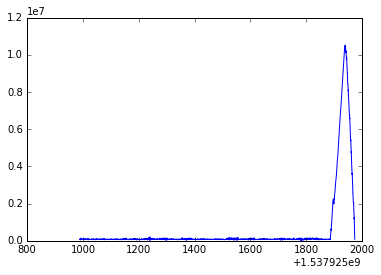

In [25]:
print(column_names)
plt.plot(df_upStatus['time']/1000,df_upStatus['left_size'])
plt.show()

In [28]:
import numpy as np
import pandas as pd
import urllib.request
import folium
from IPython.display import display
from scipy import signal, interpolate

sTimeStamp = df_upStatus['time'][0]
eTimeStamp = df_upStatus['time'][len(df_upStatus['time'])-1]

column_names, df_gps = gps.get_DataFrameFromTime( sTimeStamp, eTimeStamp )

#interpolate linear
f_upStatus = interpolate.interp1d(np.array(df_upStatus['time'],dtype=np.float),df_upStatus['left_size'])
upStatus_interpolate = f_upStatus(np.array(df_gps['time'],dtype=np.float))
a
loc = [df_gps['latitude'][0], df_gps['longitude'][0]]
map_obj =folium.Map(location=loc, zoom_start=14)
#folium.Marker(loc,popup=str(''), icon=folium.Icon(color='blue',icon='info-sign')).add_to(map_obj)
for i in range(len(df_gps['latitude'])):
    folium.CircleMarker([df_gps['latitude'][i],df_gps['longitude'][i]], radius=upStatus_interpolate[i]/100000,popup='',color='#3186cc', fill_color='#3186cc').add_to(map_obj)

display(map_obj)